In [61]:
import pandas as pd
import pywt
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

import multiprocessing
import matplotlib.pyplot as plt
import pywt

import os
import shutil
import random

# Load the datasets
with open("Normal_120s.pkl", "rb") as f:
    normal_data = pd.read_pickle(f)

with open("Vibration_120s.pkl", "rb") as f:
    vibration_data = pd.read_pickle(f)

# with open("RampUpDown_120s.pkl", "rb") as f:
#     rampupdown_data = pd.read_pickle(f)
    
with open("RampUpDown_300s_Labelled.pkl", "rb") as f:
    rampupdown_data = pd.read_pickle(f)

with open("Friction_120s.pkl", "rb") as f:
    friction_data = pd.read_pickle(f)

with open("Data\Friction_low_120s.pkl", "rb") as f:
    friction_low_data = pd.read_pickle(f)

with open("Data\Vibration_low_120s.pkl", "rb") as f:
    vibration_low_data = pd.read_pickle(f)

In [62]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

MAX_ITER = 1000
N_CLASSES = 3

SEQUENCE_LENGTH = 400

DATA_SETS = ["normal_data", "rampupdown_data"]
DATA_SETS_F = []
for val in DATA_SETS:
    if val == "rampupdown_data":
        DATA_SETS_F.append("rampUp_data")
        DATA_SETS_F.append("rampDown_data")
    else:
        DATA_SETS_F.append(val)

#Create result PATH
name = "TEST_DTW_CLUSTERING_"
name += str(N_CLASSES) + "_"
for datasets in DATA_SETS:
    name += datasets + "_"
name += "seqLen" + str(SEQUENCE_LENGTH) + "_" + "ITER" + str(MAX_ITER) + "_"
RESULT_PATH = "Results/DTW - Clustering/" + name
SEQUENCE_NAME = "SEQUENCES_"+ name +".pkl"

# Create Labels
normal_data['label'] = "normal"
vibration_data['label'] = "vibration"
rampup_data = rampupdown_data[rampupdown_data['label'] == "rampup"]
rampdown_data = rampupdown_data[rampupdown_data['label'] == "rampdown"]
friction_low_data['label'] = "friction_low"
vibration_low_data['label'] = "vibration_low"
# for i, label in enumerate(rampupdown_data['label']):
#     if label == 0:
#         rampupdown_data['label'].iloc[i] = "rampdown"
#     else:
#         rampupdown_data['label'].iloc[i] = "rampup"
# Create seperate dataset for rampup and rampdown
# rampup_data = rampupdown_data[rampupdown_data['label'] == "rampup"]
# rampdown_data = rampupdown_data[rampupdown_data['label'] == "rampdown"]
friction_data['label'] = "friction"

In [63]:
friction_data_seq = []
for i in range(0,int(len(friction_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in friction_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    friction_data_seq.append(sequence)

normal_data_seq = []
for i in range(0,int(len(normal_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in normal_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    normal_data_seq.append(sequence)

vibration_data_seq = []
for i in range(0,int(len(vibration_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in vibration_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    vibration_data_seq.append(sequence)

rampup_data_seq = []
for i in range(0,int(len(rampup_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in rampup_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    rampup_data_seq.append(sequence)

rampdown_data_seq = []
for i in range(0,int(len(rampdown_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in rampdown_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    rampdown_data_seq.append(sequence)

friction_low_data_seq = []
for i in range(0,int(len(friction_low_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in friction_low_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    friction_low_data_seq.append(sequence)

vibration_low_data_seq = []
for i in range(0,int(len(vibration_low_data)/SEQUENCE_LENGTH)):
    sequence = []
    for values in vibration_low_data['ax_motor'][i*SEQUENCE_LENGTH:(i+1)*SEQUENCE_LENGTH]:
        sequence.append(values)
    vibration_low_data_seq.append(sequence)

In [64]:
normal_data_seq

[[-0.038330078125,
  -0.0045166015625,
  -0.01873779296875,
  -0.05401611328125,
  -0.05792236328125,
  -0.07867431640625,
  -0.056884765625,
  -0.09442138671875,
  -0.06866455078125,
  -0.08966064453125,
  -0.08831787109375,
  -0.0675048828125,
  -0.0533447265625,
  -0.03741455078125,
  -0.02032470703125,
  -0.02081298828125,
  -0.002197265625,
  0.00506591796875,
  -0.01080322265625,
  0.0137939453125,
  0.00823974609375,
  0.0186767578125,
  0.031005859375,
  -0.03424072265625,
  -0.00634765625,
  -0.0302734375,
  -0.04986572265625,
  -0.05792236328125,
  -0.07708740234375,
  -0.0665283203125,
  -0.0909423828125,
  -0.06817626953125,
  -0.093505859375,
  -0.08660888671875,
  -0.06207275390625,
  -0.05609130859375,
  -0.0343017578125,
  -0.014404296875,
  -0.02593994140625,
  0.00457763671875,
  0.00164794921875,
  -0.0096435546875,
  0.01885986328125,
  -0.005859375,
  0.02484130859375,
  0.04315185546875,
  -0.03643798828125,
  -0.015380859375,
  -0.0286865234375,
  -0.04345703125,

In [65]:
# Use sklearn K-Meiods to cluster the data using DTW as the distance metric

from sklearn_extra.cluster import KMedoids
from tslearn.metrics import dtw

# Create the dataset. The dataset should be normal_data_seq + vibration_data_seq after eachother
data = normal_data_seq + vibration_data_seq + friction_data_seq + rampup_data_seq + rampdown_data_seq + vibration_low_data_seq + friction_low_data_seq

# Create the labels
labels = ["Normal"]*len(normal_data_seq) + ["Vibration_"]*len(vibration_data_seq) + ["Friction_"]*len(friction_data_seq) + ["RampUp"]*len(rampup_data_seq) + ["RampDown"]*len(rampdown_data_seq) + ["VibrationLow"]*len(vibration_low_data_seq) + ["FrictionLow"]*len(friction_low_data_seq)

# Create the K-Medoids model
kmedoids = KMedoids(n_clusters=N_CLASSES, metric=dtw, random_state=6, max_iter=MAX_ITER)

# Fit the model
kmedoids.fit(data)

# Get the cluster labels
cluster_labels = kmedoids.predict(data)

# Get the cluster medoids
cluster_medoids = kmedoids.cluster_centers_

In [66]:
print(len(cluster_labels))
print(len(labels))

2101
2101


In [67]:
df = pd.DataFrame()
df['File'] = labels
df['Class'] = cluster_labels

df

,File,Class
0,Normal,2
1,Normal,2
2,Normal,2
3,Normal,2
4,Normal,2
...,...,...
2096,FrictionLow,1
2097,FrictionLow,1
2098,FrictionLow,1
2099,FrictionLow,1


In [68]:
def countUniquesByClass(df, class_name, N_CLASSES):

    df = df[df['File'].str.startswith(class_name)]
    counts = [0 for i in range(N_CLASSES)]
    counts_str = [str(i) for i in range(N_CLASSES)]
    # Create a hashmap with counts_str and counts
    counts_dict = dict(zip(counts_str, counts))
    
    
    for values in df['Class'].values:
        counts_dict[str(values)] += 1

    return counts_dict

In [69]:
Normal_map = (countUniquesByClass(df, 'Normal', N_CLASSES))
# Friction_map = (countUniquesByClass(df, 'Friction', N_CLASSES))
# Vibration_map = (countUniquesByClass(df, 'Vibration', N_CLASSES))
# RampUp_map = (countUniquesByClass(df, 'RampUp', N_CLASSES))
# RampDown_map = (countUniquesByClass(df, 'RampDown', N_CLASSES))


print(Normal_map)
# print(Friction_map)
# print(Vibration_map)
# print(RampUp_map)
# print(RampDown_map)


{'0': 0, '1': 0, '2': 300}


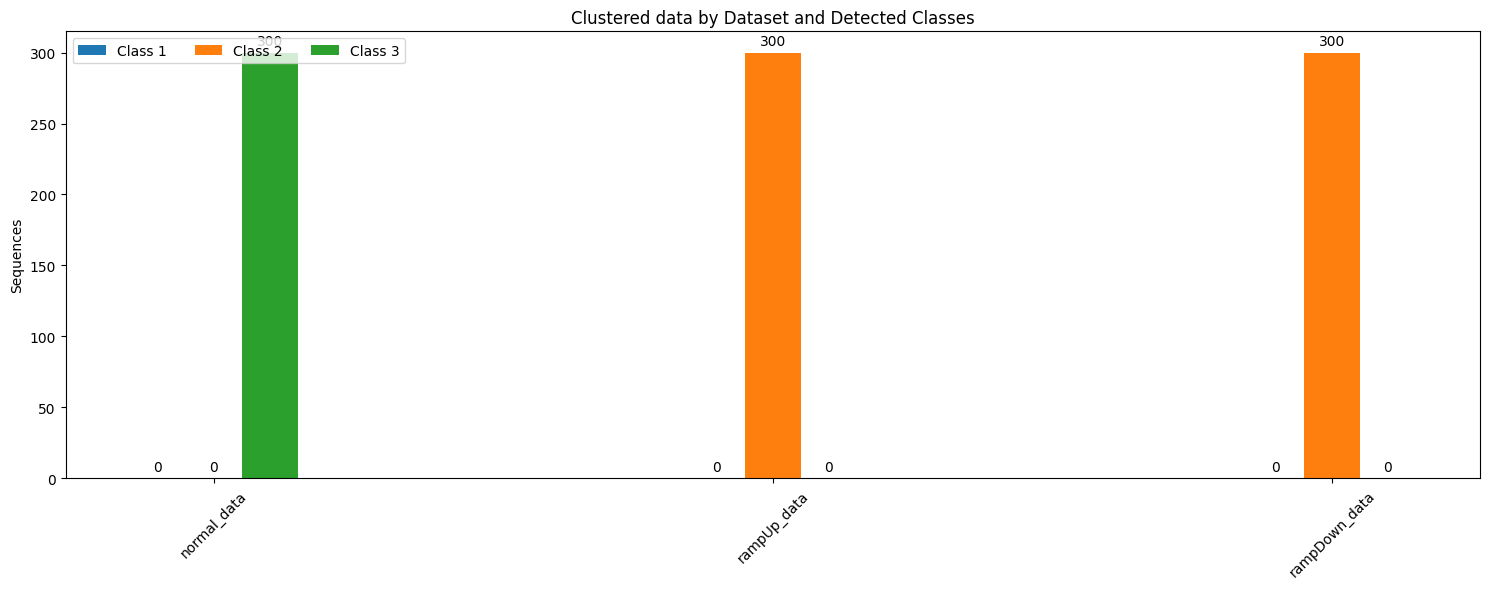

In [70]:
Normal_map = (countUniquesByClass(df, 'Normal', N_CLASSES))
# Friction_map = (countUniquesByClass(df, 'Friction_', N_CLASSES))
# Vibration_map = (countUniquesByClass(df, 'Vibration_', N_CLASSES))
RampUp_map = (countUniquesByClass(df, 'RampUp', N_CLASSES))
RampDown_map = (countUniquesByClass(df, 'RampDown', N_CLASSES))
# Friction_low_map = (countUniquesByClass(df, 'FrictionLow', N_CLASSES))
# Vibration_low_map = (countUniquesByClass(df, 'VibrationLow', N_CLASSES))

#classes = ("Normal", "Vibration","Friction")#, "Vibration", "RampUp", "RampDown")
detected_classes = {
    'Class 1' : (Normal_map['0'], RampUp_map['0'], RampDown_map['0']),
    'Class 2' : (Normal_map['1'], RampUp_map['1'], RampDown_map['1']),
    'Class 3' : (Normal_map['2'], RampUp_map['2'], RampDown_map['2']),
    # 'Class 1' : (Normal_map['0'], Vibration_map['0'], Friction_map['0'], RampUp_map['0'], RampDown_map['0'], Vibration_low_map['0'], Friction_low_map['0']),
    # 'Class 2' : (Normal_map['1'], Vibration_map['1'], Friction_map['1'], RampUp_map['1'], RampDown_map['1'], Vibration_low_map['1'], Friction_low_map['1']),
    # 'Class 3' : (Normal_map['2'], Vibration_map['2'], Friction_map['2'], RampUp_map['2'], RampDown_map['2'], Vibration_low_map['2'], Friction_low_map['2']),
    # 'Class 4' : (Normal_map['3'], Vibration_map['3'], Friction_map['3'], RampUp_map['3'], RampDown_map['3'], Vibration_low_map['3'], Friction_low_map['3']),
    # 'Class 5' : (Normal_map['4'], Vibration_map['4'], Friction_map['4'], RampUp_map['4'], RampDown_map['4'], Vibration_low_map['4'], Friction_low_map['4']),
    # 'Class 6' : (Normal_map['5'], Vibration_map['5'], Friction_map['5'], RampUp_map['5'], RampDown_map['5'], Vibration_low_map['5'], Friction_low_map['5']),
    # 'Class 7' : (Normal_map['6'], Vibration_map['6'], Friction_map['6'], RampUp_map['6'], RampDown_map['6'], Vibration_low_map['6'], Friction_low_map['6']),
    


}

x = np.arange(len(DATA_SETS_F))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='tight')

for attribute, measurement in detected_classes.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sequences')
ax.set_title('Clustered data by Dataset and Detected Classes')
ax.set_xticks(x + width, DATA_SETS_F)
ax.legend(loc='upper left', ncols=N_CLASSES)
# Add spacing between the plots
plt.xticks(rotation=45)
ax.figure.set_size_inches(15, 6)
ax.set_ylim(bottom=0)
plt.savefig(RESULT_PATH + "GRAPH.png")
plt.show()

In [71]:
RESULT_PATH

'Results/DTW - Clustering/TEST_DTW_CLUSTERING_3_normal_data_rampupdown_data_seqLen400_ITER1000_'